# Step 1. Setup Env

In [1]:
# !pip install recogym

In [2]:
from recogym.envs.session import OrganicSessions

from numpy.random.mtrand import RandomState
from recogym import Configuration, DefaultContext, Observation
from recogym.agents import Agent
from recogym.agents import organic_user_count_args, OrganicUserEventCounterAgent
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from recogym.evaluate_agent import verify_agents, plot_verify_agents
from recogym.agents import FeatureProvider

import math
import gym
from copy import deepcopy
from recogym import env_1_args
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE


%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 3]

In [3]:
def get_recogym_configuration(num_products, random_seed=42):
    return Configuration({
        **env_1_args, 
        'random_seed': random_seed,
        'num_products': num_products,
        # 'phi_var': 0.0,
        # 'sigma_mu_organic': 0.,
        # 'sigma_omega': 0.,
        # 'K': 5,
        # 'number_of_flips': 5,
    })


def get_environement(num_products, random_seed=42):
    env = gym.make('reco-gym-v1')
    env.init_gym(get_recogym_configuration(num_products, random_seed=random_seed).__dict__)
    
    return env

# Step 2. Generate the training data and derive the raw features

In [4]:
NUM_USERS = 1000
NUM_PRODUCTS = 10

organic_counter_agent = OrganicUserEventCounterAgent(Configuration({
           **organic_user_count_args,
           **get_recogym_configuration(NUM_PRODUCTS).__dict__,
           'select_randomly': True,
       }))

env = get_environement(NUM_PRODUCTS)
popularity_policy_logs = env.generate_logs(NUM_USERS, organic_counter_agent)

In [5]:
class ProductCountFeatureProvider(FeatureProvider):
    """This feature provider creates a user state based on viewed product count.
    Namely, the feature vector of shape (n_products, ) contains for each product how many times the
    user has viewed them organically.
    """

    def __init__(self, config):
        super(ProductCountFeatureProvider, self).__init__(config)
        self.feature_data = np.zeros((self.config.num_products)).astype(int)

    def observe(self, observation):
        for session in observation.sessions():
            self.feature_data[int(session['v'])] += 1

    def features(self, observation):
        return self.feature_data.copy()

    def reset(self):
        self.feature_data[:] = 0


def build_rectangular_data(logs, feature_provider):
    """Create a rectangular feature set from the logged data.
    For each taken action, we compute the state in which the user was when the action was taken
    """
    user_states, actions, rewards, proba_actions = [], [], [], []
    
    current_user = None
    for _, row in logs.iterrows():
        if current_user != row['u']:
            # Use has changed: start a new session and reset user state
            current_user = row['u']
            sessions = OrganicSessions()
            feature_provider.reset()
        
        context = DefaultContext(row['u'], row['t'])
        
        if row['z'] == 'organic':
            sessions.next(context, row['v'])
            
        else:
            # For each bandit event, generate one observation for the user state, the taken action
            # the obtained reward and the used probabilities
            feature_provider.observe(Observation(context, sessions))
            user_states += [feature_provider.features(None)] 
            actions += [row['a']]
            rewards += [row['c']]
            proba_actions += [row['ps']] 
            
            # Start a new organic session
            sessions = OrganicSessions()
    
    return np.array(user_states), np.array(actions).astype(int), np.array(rewards), np.array(proba_actions)

In [6]:
# You can now see data that will be provided to our agents based on logistic regressions
count_product_views_feature_provider = ProductCountFeatureProvider(config=get_recogym_configuration(NUM_PRODUCTS))
user_states, actions, rewards, proba_actions = \
    build_rectangular_data(popularity_policy_logs, count_product_views_feature_provider)

In [7]:
preview_start, preview_size = 500, 3

print('user product views count at action time')
print(user_states[preview_start:preview_start + preview_size])
print('taken actions', actions[preview_start:preview_start + preview_size])
print('obtained rewards', rewards[preview_start:preview_start + preview_size])
print('probablities of the taken actions', proba_actions[preview_start:preview_start + preview_size])

user product views count at action time
[[0 0 0 1 1 5 0 0 0 0]
 [0 0 0 1 2 7 0 0 0 0]
 [0 0 0 1 2 7 0 0 0 0]]
taken actions [5 5 5]
obtained rewards [1. 0. 0.]
probablities of the taken actions [0.71428571 0.7        0.7       ]


Each product is shown with a probability proportional to the number of times it has been seen by the user relatively to the others products.

# Step 3.A. Define and train the bandit likelihood agent

In order to be able to make the link between the state and the actions, we need to create cross-features that show how good a certain pair of state,action is from the pv of predicting pClick (pReward)

In [8]:
class LikelihoodAgent(Agent):
    def __init__(self, feature_provider, use_argmax=False, seed=43):
        self.feature_provider = feature_provider
        self.use_argmax = use_argmax
        self.random_state = RandomState(seed)
        self.model = None
        
    @property
    def num_products(self):
        return self.feature_provider.config.num_products
    
    def _create_features(self, user_state, action):
        """Create the features that are used to estimate the expected reward from the user state.
        """
        features = np.zeros(len(user_state) * self.num_products)
        features[action * len(user_state): (action + 1) * len(user_state)] = user_state
        
        return features
    
    def train(self, logs):
        user_states, actions, rewards, proba_actions = build_rectangular_data(logs, self.feature_provider)
        
        features = np.vstack([
            self._create_features(user_state, action) 
            for user_state, action in zip(user_states, actions)
        ])
        self.model = LogisticRegression(solver='lbfgs', max_iter=5000)
        self.model.fit(features, rewards)
    
    def _score_products(self, user_state):
        all_action_features = np.array([
            self._create_features(user_state, action) 
            for action in range(self.num_products)
        ])
        return self.model.predict_proba(all_action_features)[:, 1]
        
    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past history"""
        self.feature_provider.observe(observation)        
        user_state = self.feature_provider.features(observation)
        prob = self._score_products(user_state)
        
        if not self.use_argmax:
            action = self.random_state.choice(self.num_products, p=(prob / np.sum(prob)))
            ps = prob[action]
            all_ps = prob.copy()
        else:
            action = np.argmax(prob)
            ps = 1.0
            all_ps = np.zeros(self.num_products)
            all_ps[action] = 1.0
      
        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'expected-value': prob[action],
                'ps': ps,
                'ps-a': all_ps,
            }
        }

    def reset(self):
        self.feature_provider.reset()  

In [9]:
# Have a look at the feature vector used by the Likelihood agent
picked_sample = 500

count_product_views_feature_provider = ProductCountFeatureProvider(get_recogym_configuration(NUM_PRODUCTS))
likelihood_logreg = LikelihoodAgent(count_product_views_feature_provider)

print('User state', user_states[picked_sample])
print('action', actions[picked_sample])
print('Created cross features')
print(likelihood_logreg._create_features(user_states[picked_sample], actions[picked_sample]))

User state [0 0 0 1 1 5 0 0 0 0]
action 5
Created cross features
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [10]:
%%time

likelihood_logreg = LikelihoodAgent(count_product_views_feature_provider, use_argmax=True)
likelihood_logreg.train(popularity_policy_logs)

CPU times: user 40.6 s, sys: 2.12 s, total: 42.7 s
Wall time: 21.3 s


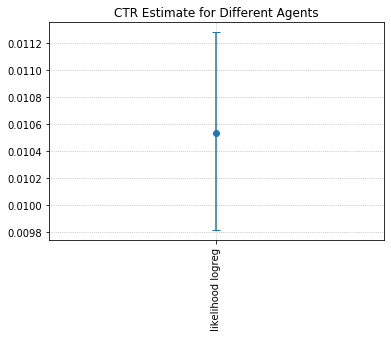

CPU times: user 15.3 s, sys: 207 ms, total: 15.5 s
Wall time: 15.6 s


In [11]:
%%time

result = verify_agents(env, NUM_USERS, {'likelihood logreg': likelihood_logreg})
fig = plot_verify_agents(result)
plt.grid(linestyle=":")
plt.show()

# Step 3.B. Dissect likelihood agent behavior

In [12]:
def run_agent(env, num_users, agent):
    """Small utility function to collect stats about you agent on simulated test traffic
    It is really recogym specific, you do not need to look at its internal details
    """
    env = deepcopy(env)
    env.agent = agent  
    
    events = []
    for user_id in range(num_users):
        env.reset(user_id)
        observation, reward, done, _ = env.step(None)

        while not done:
            for session in observation.sessions():
                events += [{**session, 'z': 'organic'}]

            action, observation, reward, done, info = env.step_offline(observation, reward, done)
            events += [{**action, 'z': 'bandit', 'c': reward}]

            if done:
                break

    events_df = pd.DataFrame().from_dict(events)
    ordered_cols = ['t', 'u', 'z', 'v', 'a', 'c', 'ps', 'ps-a']
    all_cols = ordered_cols + [col for col in events_df.columns if col not in ordered_cols]
    return events_df[all_cols]


In [13]:
n_test_users = 1000
likelihood_logreg_test_logs = run_agent(env, n_test_users, likelihood_logreg)

Text(0.5, 0, 'Selected product')

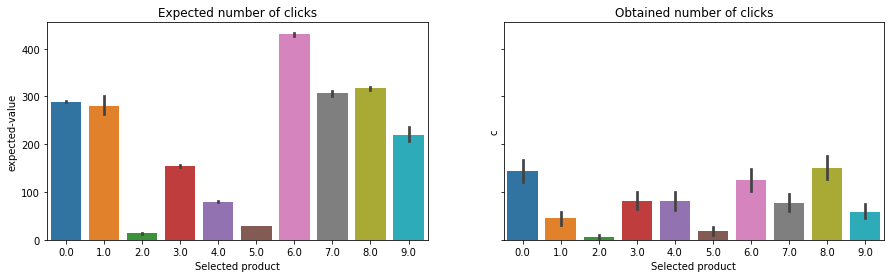

In [14]:
# To force the arms to share the same colors
palette = {c: f'C{c}' for c in range(NUM_PRODUCTS)} if NUM_PRODUCTS < 20 else None

fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
sns.barplot(x="a", y="expected-value", data=likelihood_logreg_test_logs, ax=axes[0], estimator=sum, palette=palette)
axes[0].set_title('Expected number of clicks')
axes[0].set_xlabel('Selected product')

sns.barplot(x="a", y="c", data=likelihood_logreg_test_logs, ax=axes[1], estimator=sum, palette=palette)
axes[1].set_title('Obtained number of clicks')
axes[1].set_xlabel('Selected product')

The number of clicks is highly over estimated. This is a good illustration of the optimizer curse.

# Step 4. Define and train the Contextual Bandit agent - VanillaCB

In [15]:
class PolicyAgent(LikelihoodAgent):
    def __init__(self, feature_provider, use_argmax=False, seed=43):
        LikelihoodAgent.__init__(self, feature_provider, use_argmax=use_argmax, seed=seed)
    
    def _create_features(self, user_state, action):
        """Create the features that are used to estimate the expected reward from the user state.
        """
        return user_state
    
    def train(self, reco_log):
        user_states, actions, rewards, proba_actions = build_rectangular_data(reco_log, self.feature_provider)
        
        features = np.vstack([
            self._create_features(user_state, action) 
            for user_state, action in zip(user_states, actions)
        ])        
        labels = actions
        weights = rewards / proba_actions
        
        self.model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000)        
        self.model.fit(features[weights != 0], labels[weights != 0], weights[weights != 0])
    
    def _score_products(self, user_state):
        return self.model.predict_proba(self._create_features(user_state, None).reshape(1, -1))[0, :]


In [16]:
%%time

policy_logreg = PolicyAgent(count_product_views_feature_provider, use_argmax=True)
policy_logreg.train(popularity_policy_logs)

CPU times: user 13.3 s, sys: 112 ms, total: 13.4 s
Wall time: 13.4 s


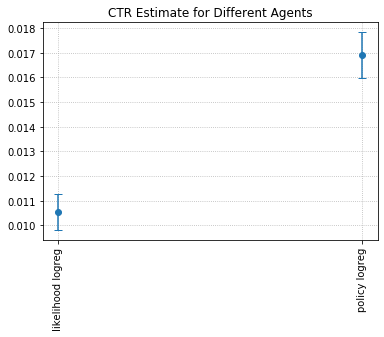

In [17]:
result = verify_agents(env, NUM_USERS, {
    'likelihood logreg': likelihood_logreg, 
    'policy logreg': policy_logreg,
})
fig = plot_verify_agents(result)
plt.grid(linestyle=":")
plt.show()

The policy agent achieves way better CTR than the likelihood agent

In [18]:
policy_logreg_test_logs = run_agent(env, 1000, policy_logreg)

Text(0, 0.5, 'Number of times this product has been shown')

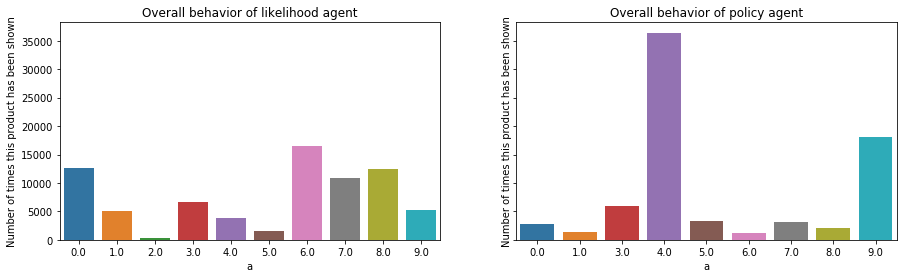

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
sns.countplot(x="a", data=likelihood_logreg_test_logs, ax=axes[0], palette=palette)
axes[0].set_title('Overall behavior of likelihood agent')
axes[0].set_ylabel('Number of times this product has been shown')

sns.countplot(x="a", data=policy_logreg_test_logs, ax=axes[1], palette=palette)
axes[1].set_title('Overall behavior of policy agent')
axes[1].set_ylabel('Number of times this product has been shown')

The two agents behave quite differently, the policy agent focuses on the very best arms.

Text(0, 0.5, 'CTR')

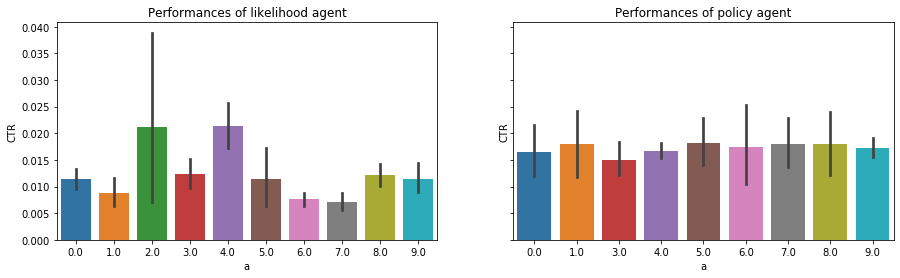

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
sns.barplot(x="a", y="c", data=likelihood_logreg_test_logs, ax=axes[0], palette=palette)
axes[0].set_title('Performances of likelihood agent')
axes[0].set_ylabel('CTR')

sns.barplot(x="a", y="c", data=policy_logreg_test_logs, ax=axes[1], palette=palette)
axes[1].set_title('Performances of policy agent')
axes[1].set_ylabel('CTR')

While focusing on the very best arms, the policy agent has a way better CTR for almost all products, namely it is better at choosing which product should be shown.

# Step 5.A. Define and train Contextual Bandit agent on top product embeddings space - OrganicCB

In [21]:
# Embeddings from previous notebook
def create_embeddings(reco_log, num_products, embedding_size=5):
    organic_reco_log = reco_log[reco_log['z'] == 'organic']

    n_users = reco_log['u'].nunique()
    counts = np.zeros((n_users, num_products))

    binarizer = LabelBinarizer().fit(np.arange(num_products))
    for u in range(n_users):
        binarized_views_of_user = binarizer.transform(organic_reco_log[organic_reco_log['u'] == u]['v'])
        counts[u, :] = binarized_views_of_user.sum(axis=0)

    counts_above_zero = 1. * (counts > 0)  # above zero counts only
    co_counts = np.matmul(counts_above_zero.T, counts_above_zero)

    w, v = np.linalg.eig(co_counts)
    idx = np.argsort(w)[::-1]
    v = np.real(v[:, idx])
    w = np.real(w[idx])

    wdash = np.zeros_like(w)

    wdash[0: embedding_size] = w[0: embedding_size]
    embeddings = np.matmul(v, np.sqrt(np.diag(wdash)))[:, 0: embedding_size]  # keep the non-zero components
    return embeddings

In [22]:
class PolicyAgentWithEmbeddings(LikelihoodAgent):
    def __init__(self, feature_provider, use_argmax=False, seed=43):
        LikelihoodAgent.__init__(self, feature_provider, use_argmax=use_argmax, seed=seed)
        self.embeddings = None
    
    def _create_features(self, user_state, action):
        """Create the features that are used to estimate the expected reward from the user state.
        """
        # User state is the number of time each product has been seen
        # We do a weigthed average of these products and use them as features
        return np.average(self.embeddings, axis=0, weights=user_state)
    
    def train(self, reco_log):
        user_states, actions, rewards, proba_actions = build_rectangular_data(reco_log, self.feature_provider)
        self.embeddings = create_embeddings(reco_log, self.num_products)
        
        features = np.vstack([
            self._create_features(user_state, action) 
            for user_state, action in zip(user_states, actions)
        ])        
        labels = actions
        weights = rewards / proba_actions
                
        self.model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000)        
        self.model.fit(features[weights != 0], labels[weights != 0], weights[weights != 0])
    
    def _score_products(self, user_state):
        return self.model.predict_proba(self._create_features(user_state, None).reshape(1, -1))[0, :]


In [23]:
%%time

policy_logreg_with_embeddings = PolicyAgentWithEmbeddings(count_product_views_feature_provider, use_argmax=True)
policy_logreg_with_embeddings.train(popularity_policy_logs)

CPU times: user 17.9 s, sys: 161 ms, total: 18.1 s
Wall time: 18.2 s


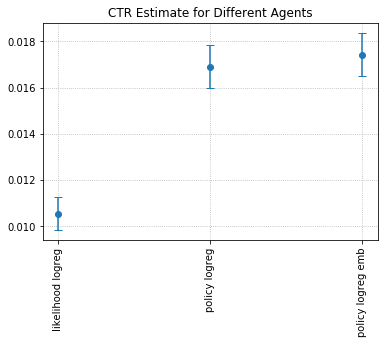

In [24]:
result = verify_agents(env, NUM_USERS, {
    'likelihood logreg': likelihood_logreg, 
    'policy logreg': policy_logreg,
    'policy logreg emb': policy_logreg_with_embeddings,    
})
fig = plot_verify_agents(result)
plt.grid(linestyle=":")
plt.show()

# Step 5.B. Representation of products and users in the embedding space

In [25]:
def plot_embedded_user_states_and_products(user_states, product_embeddings, actions):    
    # Transform user states
    embedded_user_states = [
        policy_logreg_with_embeddings._create_features(user_state, None)
        for user_state in user_states
    ]
    
    # We now want to represent them with products in two dimensions
    tsne = TSNE(n_components=2)
    all_vectors_to_project = np.vstack((product_embeddings, embedded_user_states))
    
    projected_vectors = tsne.fit_transform(all_vectors_to_project)

    projected_user_states = projected_vectors[len(product_embeddings):]
    projected_products = projected_vectors[: len(product_embeddings)]
    
    plt.figure(figsize=(12, 6))
    plt.scatter(projected_user_states[:, 0], projected_user_states[:, 1], 
                    alpha=0.4, c=[f'C{x}' for x in actions], s=10)

    for i in range(len(projected_products)):
        plt.scatter(projected_products[i, 0], projected_products[i, 1],
                   c=f'C{i}', s=500, marker='*', label=f'$p_{{{i}}}$')
        
    plt.legend()

In [26]:
policy_logreg_with_embeddings_logs = env.generate_logs(NUM_USERS, policy_logreg_with_embeddings)

<Figure size 720x504 with 0 Axes>

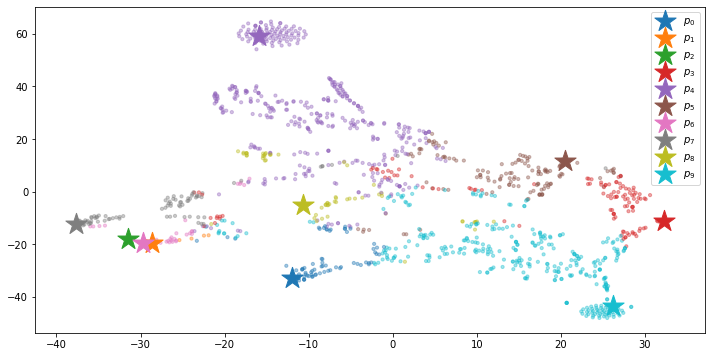

In [27]:
# Create embeddings on the train logs
embeddings = create_embeddings(popularity_policy_logs, NUM_PRODUCTS)

# project these embeddings with user states from the test logs
user_states, actions, rewards, proba_actions = build_rectangular_data(
    policy_logreg_with_embeddings_logs, count_product_views_feature_provider)

user_states_with_clicks = user_states[rewards == 1]
actions_with_clicks = actions[rewards == 1]

plt.figure(figsize=(10, 7))
plot_embedded_user_states_and_products(user_states_with_clicks, embeddings, actions_with_clicks)

Thanks to the products embeddings built with organic data, we can transfer knowledge the train log to the test log. The user states that have led to clicks in the test log are indeed linked to the embeddings from the train log of these products.

# Step 6. KNNAgent for scaling

Based on this observation, one can derive an agent that exploits this directly and can scale to millions of products.

In [35]:
from scipy import spatial

class KNNAGent(LikelihoodAgent):
    def __init__(self, feature_provider, use_argmax=True, seed=43):
        LikelihoodAgent.__init__(self, feature_provider, use_argmax=use_argmax, seed=seed)
        self.embeddings = None
        self.kdd_tree = None
    
    def _create_features(self, user_state, action):
        """Create the features that are used to estimate the expected reward from the user state.
        """
        # User state is the number of time each product has been seen
        # We do a weigthed average of these products and use them as features
        return np.average(self.embeddings, axis=0, weights=user_state)
    
    def train(self, reco_log):
        self.embeddings = create_embeddings(reco_log, self.num_products)
        self.kdd_tree = spatial.KDTree(self.embeddings)
    
    def _score_products(self, user_state):
        # For an easier integration, we "fake" scores
        action = self.kdd_tree.query(self._create_features(user_state, None))[1]
        scores = np.zeros(self.num_products)
        scores[action] = 1
        return scores

In [36]:
knn_agent = KNNAGent(count_product_views_feature_provider, use_argmax=True)
knn_agent.train(popularity_policy_logs)

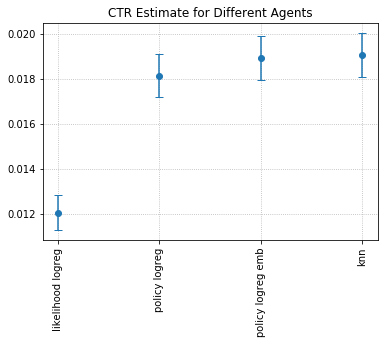

In [37]:
result = verify_agents(env, NUM_USERS, {
    'likelihood logreg': likelihood_logreg, 
    'policy logreg': policy_logreg,
    'policy logreg emb': policy_logreg_with_embeddings,
    'knn': knn_agent,
})
fig = plot_verify_agents(result)
plt.grid(linestyle=":")
plt.show()